# Palm Oil Futures: Part B Setup

I need to first get the "all to left" dataframe. Then, I'll group by Month and take First and Last values. 

For each month, I'll calculate its gap against the previous month's end. This will then be turned into a cumulative gap by adding them up, which can be joined to the main dataframe.

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [62]:
# bring in data with path for either work or home computer, then filter to 2019 onwards and set index as Time

# palm_futures = pd.read_csv("C:/Users/jonah/Documents/A_MFRE_work_from_home/501/futures_assignment/shift_left.csv")

palm_futures = pd.read_csv("C:/Users/jizatt/Documents/Courses/FRE_501/futures_contracts/futures_assignment/shift_left.csv")

palm_futures = palm_futures[palm_futures["Time"] >= "2019-01-01"]

palm_futures.set_index("Time", inplace = True)

palm_futures.rename(columns={"cuf19": "price"}, inplace = True)

In [63]:
palm_futures.head()

,price
Time,
2019-01-02,523.50
2019-01-03,519.25
2019-01-04,524.50
2019-01-07,524.75
2019-01-08,528.75


In [64]:
# Convert the index to datetime format
palm_futures.index = pd.to_datetime(palm_futures.index)

# Check if the index is ordered in ascending "Time" order
is_ordered = palm_futures.index.is_monotonic_increasing

if is_ordered:
    print("DataFrame is ordered in ascending 'Time' order.")
else:
    print("DataFrame is not ordered in ascending 'Time' order.")
    
# create Month column for Group By, Merging
palm_futures['Month'] = palm_futures.index.strftime('%Y-%m')

DataFrame is ordered in ascending 'Time' order.


In [65]:
# create dataframes of first and last trading days in each month

month_firsts  = palm_futures.groupby("Month").first()
month_lasts = palm_futures.groupby("Month").last()

# calculate profits over the month
month_profits = month_lasts["price"] - month_firsts["price"]

month_profits.head()

Month
2019-01    15.25
2019-02   -11.75
2019-03   -15.25
2019-04     8.00
2019-05   -18.50
Name: price, dtype: float64

In [66]:
# sum total monthly profits, for fun:

month_profits.sum()

383.25

Quick Peek at roll yield myth supposed profit: 

In [67]:
month_lasts["price"].tail(1)

Month
2023-08    836.0
Name: price, dtype: float64

In [68]:
month_firsts["price"].head(1)

Month
2019-01    523.5
Name: price, dtype: float64

In [69]:
836.0 - 523.5

312.5

# Calculating Synthetic Curve

The prices we observe for futures are not true representation of profits and gains from holding the asset in the long-term, due to the Roll Yield, which represents storage costs (when a positive cost) or a convenience premium for deferring commodity use (when a negative cost, or profit). 

We want to calculate the Synthetic Curve, which represents the actual path of profits, with gains or losses over time. 


`Price = Base Price + Within-Month Profit + Between-Month Gaps`

Both of these are cumulative over time. So there are actually two valid approaches to get the Synthetic Curve:

1. `Synthetic Curve` = `Price - Between-Month Gaps`

In this case, we would take each Month(i) end value and the Month(i+1) start value, and subtract the former from the latter to get their gap. We then cumulatively sum all month gaps and join these onto the main prices dataframe, and subtract the cumulative gap value from the real price curve. 

Since we've removed the `Between-Month Gaps`, we've got the part of the overall `Price` that's equal to the `Base Price` (which doesn't particularly matter for future monthly changes) and the `Within-Month Profit`, which we are actually interested in 


2. `Synthetic Curve` = `Base Price + Within-Month Profit`

There's another way we can calculate the Synthetic Curve, which is simpler conceptually, if not computationally. 

We have: 

`Price = Base Price + Within-Month Profit + Between-Month Gaps`

`Synthetic Curve = Price - Between-Month Gaps`

What if we substitute `Price` into `Synthetic Curve`?

`Synthetic Curve = Base Price + Within-Month Profit + Between-Month Gaps - Between-Month Gaps`

`Synthetic Curve = Base Price + Within-Month Profit`

So, if we take the base price at the start of the observation period (2019), and then add just the `Within-Month Profit` values, then we'd also get the Synthetic Curve.


The problem with Approach 2 is that it's easy to calculate the End-Start values for each month, and even join these to a dataframe and add them to base price, but getting the daily shifts (without the between-month shifts) is very difficult. As a result, we'll focus on removing the between-month gaps. 

### Calculating Monthly Profits

Might as well!

In [70]:
# copy month first dataframe
month_synth_prof = month_firsts.copy()

# create cumulative profit with cumulative sum of `month_profits`, the within-month profit values
month_synth_prof["cum_profit"] = month_profits.cumsum()

# calculate monthly synthetic curve
month_synth_prof["monthly_synthetic_curve"] = month_synth_prof["cum_profit"] + 523.5

month_synth_prof.head()

,price,cum_profit,monthly_synthetic_curve
Month,,,
2019-01,523.50,15.25,538.75
2019-02,562.75,3.50,527.00
2019-03,537.50,-11.75,511.75
2019-04,518.50,-3.75,519.75
2019-05,507.00,-22.25,501.25


### Approach 1: `Synthetic Curve` = `Price - Between-Month Gaps`

We will calculate the monthly gaps with `Month (i) First Value` - `Month (i-1) Last Value`. The first of these will be a `NaN` by default, and we replace it with 0. 

With these gaps, we will take a cumulative sum, and then merge them back onto the original `palm_futures` dataset at the monthly level, and subtract them from the original price series to get our `synthetic_curve`

In [71]:
month_firsts.shape

(56, 1)

In [72]:
month_lasts.shape

(56, 1)

In [73]:
month_gap = month_firsts.merge(month_lasts, on = "Month")

month_gap.rename(columns={'price_x': 'month_start', 'price_y': 'month_end'}, inplace=True)


In [74]:
month_gap.head()

,month_start,month_end
Month,,
2019-01,523.50,538.75
2019-02,562.75,551.00
2019-03,537.50,522.25
2019-04,518.50,526.50
2019-05,507.00,488.50


In [75]:
month_gap["lag_end"] = month_gap["month_end"].shift(1)

month_gap.head()

,month_start,month_end,lag_end
Month,,,
2019-01,523.50,538.75,NaN
2019-02,562.75,551.00,538.75
2019-03,537.50,522.25,551.00
2019-04,518.50,526.50,522.25
2019-05,507.00,488.50,526.50


In [76]:
# create month gap by subtracting row i ending value from row i+1 starting value
month_gap["gap"] = month_gap["month_start"] - month_gap["lag_end"]

# first `lag_end` value is NaN, so I'm replacing with 0
month_gap.at[month_gap.index[0], "gap"] = 0

# create cumulative month gap
month_gap["cum_gap"] = month_gap["gap"].cumsum()

# print head
month_gap.head()

,month_start,month_end,lag_end,gap,cum_gap
Month,,,,,
2019-01,523.50,538.75,NaN,0.00,0.00
2019-02,562.75,551.00,538.75,24.00,24.00
2019-03,537.50,522.25,551.00,-13.50,10.50
2019-04,518.50,526.50,522.25,-3.75,6.75
2019-05,507.00,488.50,526.50,-19.50,-12.75


In [77]:
palm_futures.head()

,price,Month
Time,,
2019-01-02,523.50,2019-01
2019-01-03,519.25,2019-01
2019-01-04,524.50,2019-01
2019-01-07,524.75,2019-01
2019-01-08,528.75,2019-01


In [78]:
# merge the month_gap dataframe onto palm_futures
palm_futures = palm_futures.reset_index().merge(month_gap, on = "Month")

palm_futures.head()

,Time,price,Month,month_start,month_end,lag_end,gap,cum_gap
0,2019-01-02,523.50,2019-01,523.5,538.75,NaN,0.0,0.0
1,2019-01-03,519.25,2019-01,523.5,538.75,NaN,0.0,0.0
2,2019-01-04,524.50,2019-01,523.5,538.75,NaN,0.0,0.0
3,2019-01-07,524.75,2019-01,523.5,538.75,NaN,0.0,0.0
4,2019-01-08,528.75,2019-01,523.5,538.75,NaN,0.0,0.0


In [79]:
# calculate synthetic curve from `cuf19` minus cumulative gap
palm_futures["synthetic_curve"] = palm_futures["price"] - palm_futures["cum_gap"]

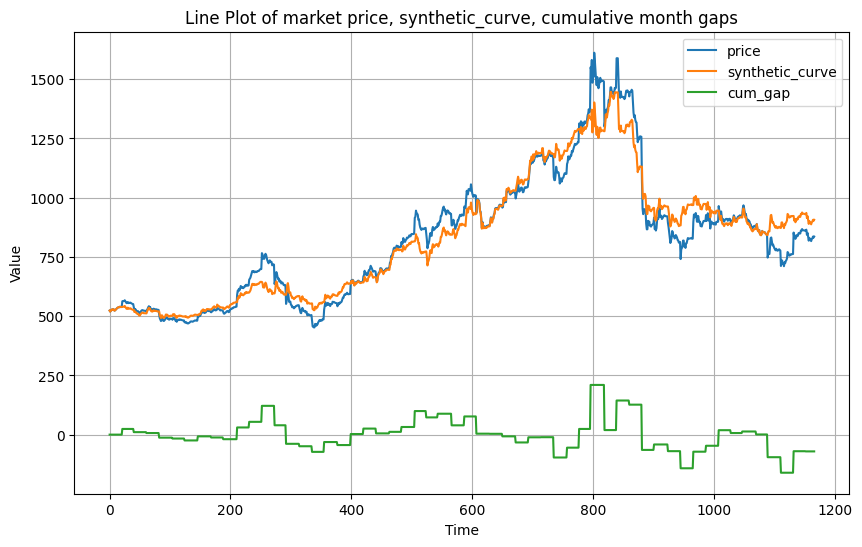

In [80]:
# Assuming you have a 'synthetic_curve' column in the DataFrame
# If not, replace 'synthetic_curve' with the actual column name
columns_to_plot = ['price', 'synthetic_curve', "cum_gap"]

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
for col in columns_to_plot:
    plt.plot(palm_futures.index, palm_futures[col], label=col)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Line Plot of market price, synthetic_curve, cumulative month gaps')
plt.legend()
plt.grid(True)
plt.show()